In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

features_dir = "../data/features/"
results_dir = "../data/results_canon/"
sentiment_dir = "../data/labels_sentiment/"
canonization_labels_dir = "../data/labels_canon/"
lang = "eng"

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_canon_labels
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import statistics
import random
random.seed(2)

labels = read_canon_labels(canonization_labels_dir)

In [3]:
'''
Fehler
Brooke_Frances_Emily_Montague_1769
Lennox_Charlotte_The-Female_Quixote_1752
Stoker_Bram-Dracula_1897

Nicolai_Friedrich_Sebaldus-Nothanker-1773
Jung-Stilling_Heinrich-Stillings-Jugend_1777
Sacher-Masoch_Venus-im-Pelz_1869
Hunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681

Hoffmansthal_Hugo ['Hoffmansthal_Hugo_Andreas-oder-die-Vereinigten_1907', 'Hoffmansthal_Hugo_Das-Maerchen-der-672-Nacht_1895'] 
Hoffmansthal_Hugo-von ['Hoffmansthal_Hugo-von_Ein-Brief_1902', 'Hoffmansthal_Hugo-von_Reitergeschichte_1899'] 


Anonymous anonymous

df = df.loc[df["book_name"] != "Defoe_Daniel_Roxana_1724"]


'''

'\nFehler\nBrooke_Frances_Emily_Montague_1769\nLennox_Charlotte_The-Female_Quixote_1752\nStoker_Bram-Dracula_1897\n\nNicolai_Friedrich_Sebaldus-Nothanker-1773\nJung-Stilling_Heinrich-Stillings-Jugend_1777\nSacher-Masoch_Venus-im-Pelz_1869\nHunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681\n\nHoffmansthal_Hugo [\'Hoffmansthal_Hugo_Andreas-oder-die-Vereinigten_1907\', \'Hoffmansthal_Hugo_Das-Maerchen-der-672-Nacht_1895\'] \nHoffmansthal_Hugo-von [\'Hoffmansthal_Hugo-von_Ein-Brief_1902\', \'Hoffmansthal_Hugo-von_Reitergeschichte_1899\'] \n\n\nAnonymous anonymous\n\ndf = df.loc[df["book_name"] != "Defoe_Daniel_Roxana_1724"]\n\n\n'

In [4]:
global_list = []

class HyperParameterOptimizer(object):
    def __init__(self, book_names=None):
        self.book_names = book_names
        # self.model = None
        # self.feature_importances_ = None
    
    def fit(self, _train_X, _train_y):
        global global_list
        n_fold = 5
        df = np.hstack((self.book_names, _train_X))
        df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(_train_X.shape[1])])
        
        print(f"Current shape of feature matrix:", _train_X.shape)
        num_boost_round = 99999

        def feval(preds, train_data):
            labels = train_data.get_label()
            return 'r2', r2_score(labels, preds)
        
        all_results = []
        for max_depth in [4]:
            for learning_rate in [0.03]:
                for colsample_bytree in [0.33]:
                    for min_child_weight in [6]:
                        train_X = deepcopy(_train_X)
                        train_y = deepcopy(_train_y)
                        dtrain = xgboost.DMatrix(train_X, label=train_y)
                        params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "min_child_weight": min_child_weight, "n_jobs": -1}
                        cv_results = xgboost.cv(
                            params,
                            dtrain,
                            num_boost_round=num_boost_round,
                            seed=40,
                            nfold=n_fold,
                            folds=AuthorSplit(df, n_fold, seed=3, return_indices=True).split(),
                            feval=feval,
                            maximize=True,
                            early_stopping_rounds=5,
                            verbose_eval=False
                        )
                        print(train_X.shape[1], max_depth, learning_rate, colsample_bytree, min_child_weight, np.round(float(cv_results["test-r2-mean"].iloc[len(cv_results["test-r2-mean"])-1]), 4))
                        all_results.append((max_depth, learning_rate, colsample_bytree, min_child_weight, cv_results))
        all_results_df = pd.DataFrame(all_results, columns=["max_depth", "learning_rate", "colsample_bytree", "min_child_weight", "cv_results"])
        all_results_df["best_validation_r2"] = all_results_df["cv_results"].apply(lambda x: x.iloc[len(x)-1]["test-r2-mean"])
        all_results_df = all_results_df.sort_values(by="best_validation_r2", ascending=False).reset_index(drop=True)
        best_parameters = all_results_df.iloc[0]
        best_max_depth = int(best_parameters["max_depth"])
        best_learning_rate = float(best_parameters["learning_rate"])
        best_colsample_bytree = float(best_parameters["colsample_bytree"])
        best_min_child_weight = float(best_parameters["min_child_weight"])
        best_validation_r2 = float(best_parameters["best_validation_r2"])
        best_num_boost_round = int(len(best_parameters["cv_results"]))
        
        print("Current best max_depth:", best_max_depth)
        print("Current best learning_rate:", best_learning_rate)
        print("Current best colsample_bytree:", best_colsample_bytree)
        print("Current best min_child_weight:", best_min_child_weight)
        print("Current best num_boost_round:", best_num_boost_round)
        print(f"Current best validation r2 score is {np.round(best_validation_r2, 4)}")
        print("############################")
        params = {"max_depth": best_max_depth, "learning_rate": best_learning_rate, "colsample_bytree": best_colsample_bytree, "min_child_weight": best_min_child_weight, "n_jobs": -1}
        
        train_X = deepcopy(_train_X)
        train_y = deepcopy(_train_y)
        dtrain = xgboost.DMatrix(train_X, label=train_y)
        model = xgboost.train(params,
                              dtrain,
                              num_boost_round=best_num_boost_round,
                              verbose_eval=False)
        feature_importances = model.get_score(importance_type='gain')
        feature_importances_list = []
        for i in range(train_X.shape[1]):
            current_key = f'f{i}'
            if current_key in feature_importances:
                feature_importances_list.append(feature_importances[current_key])
            else:
                feature_importances_list.append(0.0)
        self.model = model
        self.feature_importances_ = np.array(feature_importances_list)
        
        global_list.append((best_validation_r2, train_X.shape[1], best_num_boost_round, params))
        
        return self
    
    def predict(self, X):
        return self.model.predict(xgboost.DMatrix(X))

    def predict_proba(self, X):
        return self.predict(X)
    
    def decision_function(self, X):
        return self.predict(X)
    
    def transform(self, X):
        return self.predict(X)

    def score(self, X=None, y=None):
        return 0.0

    def get_params(self, deep=True):
        return {'book_names': self.book_names}

    def set_params(self, **params):
        self.book_names = params['book_names']
        return self

    def _get_tags(self):
        return {"allow_nan": True}

In [5]:
class AuthorSplit():
    """
    Distribute book names over splits.
    All works of an author are in the same split.
    Adapted from https://www.titanwolf.org/Network/q/b7ee732a-7c92-4416-bc80-a2bd2ed136f1/y
    Stevenson-Grift_Robert-Louis-Fanny-van-de_The-Dynamiter_1885

    """
    def __init__(self, df, nr_splits, seed, return_indices=False):
        self.df = df
        self.nr_splits = nr_splits
        self.return_indices = return_indices
        self.book_names = df["book_name"].unique()
        self.author_bookname_mapping, self.works_per_author = self.get_author_books()
        random.seed(seed)

    def get_author_books(self):
        authors = []
        author_bookname_mapping = {}
        #Get authors
        for book_name in self.book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in author_bookname_mapping:
                author_bookname_mapping[author].append(book_name)
            else:
                author_bookname_mapping[author] = []
                author_bookname_mapping[author].append(book_name)
                
        # Aggregate if author has worked anlone and with others
        if lang == "ger":
            agg_dict = {"Hoffmansthal_Hugo": ["Hoffmansthal_Hugo-von"], 
                        "Schlaf_Johannes": ["Holz-Schlaf_Arno-Johannes"],
                         "Arnim_Bettina": ["Arnim-Arnim_Bettina-Gisela"]}
        else:
            agg_dict = {"Stevenson_Robert-Louis": ["Stevenson-Grift_Robert-Louis-Fanny-van-de", 
                                                   "Stevenson-Osbourne_Robert-Louis-Lloyde"]}
            
        for author, aliases in agg_dict.items():
            if author in authors:
                for alias in aliases:
                    author_bookname_mapping[author].extend(author_bookname_mapping[alias]) 
                    del author_bookname_mapping[alias]
                    authors = [author for author in authors if author != alias]
        
        works_per_author = Counter(authors)
        return author_bookname_mapping, works_per_author
    
    def split(self):
        splits = [[] for _ in range(0,self.nr_splits)]
        totals = [(0,i) for i in range (0, self.nr_splits)]
        # heapify based on first element of tuple, inplace
        heapq.heapify(totals)
        while bool(self.works_per_author):
            author = random.choice(list(self.works_per_author.keys()))
            author_workcount = self.works_per_author.pop(author)
            # find split with smallest number of books
            total, index = heapq.heappop(totals)
            splits[index].append(author)
            heapq.heappush(totals, (total + author_workcount, index))

        if not self.return_indices:
            #Map author splits to book names
            map_splits = []
            for split in splits:
                new = []
                for author in split:
                    new.extend(self.author_bookname_mapping[author])
                map_splits.append(new)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(self.book_names))
            map_splits = []
            for split in splits:
                test_split = []
                for author in split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in  self.author_bookname_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                map_splits.append((train_split, test_split))
        return map_splits


In [6]:
class Regression():
    def __init__(self, language, features, drop_columns, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns, list)
        for i in drop_columns:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95", "rfe"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.drop_columns = drop_columns
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

    def _drop_column(self, column):
        for string in self.drop_columns:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X, train_book_names):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "rfe":
            global global_list
            best_num_boost_round = None
            hpo = HyperParameterOptimizer(book_names=train_book_names)
            rfe = RFE(hpo, step=50, n_features_to_select=10, verbose=0) # only 14 features if all columns are dropped
            rfe.fit(train_X, train_y)
            global_list = sorted(global_list, key=lambda x: -x[0])
            best_feature_count = global_list[0][1]
            best_num_boost_round = global_list[0][2]
            best_params = global_list[0][3]
            for ranking in range(rfe.ranking_.max()):
                if (rfe.ranking_ <= ranking).sum() == best_feature_count:
                    break
            train_X = train_X[:, np.argwhere((rfe.ranking_ <= ranking) == True).T[0]]
            validation_X = validation_X[:, np.argwhere((rfe.ranking_ <= ranking) == True).T[0]]
            global_list = []
        elif self.dimensionality_reduction is None:
            pass
        print('Feature Selection Done')
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=AuthorSplit(df, 5, seed=8, return_indices=True).split(),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param, class_weight="balanced")
        
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = AuthorSplit(df, 5, seed=2, return_indices=False).split() ## 10 folds
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X, train_book_names=train_df["book_name"].values.reshape(-1, 1))
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        #pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + param_dir + '_' + self.language + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value

In [7]:
'''
Parameter combinations
'''
drop_columns_list = [
    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
    ]
if lang == "eng":
    drop_columns_list.extend([
        ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
        ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"], 
        ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]
    ])
    
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} 
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', 'rfe', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

regression_params = {"model": models[2], "dimensionality_reduction": dimensionality_reduction[-1], "features": [features[0]]}
testing_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[3], "features": [features[0]]}

svr
testing eng svr book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] rfe param= 1
Dropped 300 columns.
Current shape of feature matrix: (484, 121)
121 4 0.03 0.33 6 -0.0591
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0591
############################
Current shape of feature matrix: (484, 71)
71 4 0.03 0.33 6 -0.0599
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0599
############################
Current shape of feature matrix: (484, 21)
21 4 0.03 0.33 6 -0.0594
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r

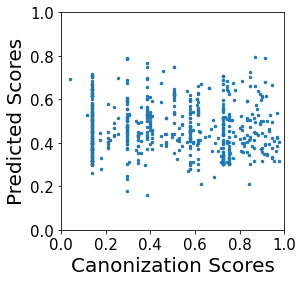

Current shape of feature matrix: (484, 121)
121 4 0.03 0.33 6 -0.0591
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0591
############################
Current shape of feature matrix: (484, 71)
71 4 0.03 0.33 6 -0.0599
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0599
############################
Current shape of feature matrix: (484, 21)
21 4 0.03 0.33 6 -0.0594
Current best max_depth: 4
Current best learning_rate: 0.03
Current best colsample_bytree: 0.33
Current best min_child_weight: 6.0
Current best num_boost_round: 1
Current best validation r2 score is -0.0594
############################
Current shape of feature matrix: (484, 10)
10 4 0.03 0.33 6 -0.0617
Current best max_dept

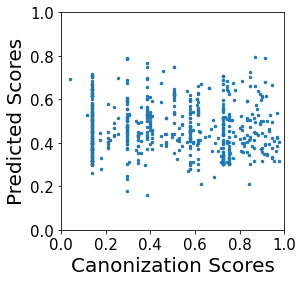

In [8]:
'''
Run Regression
'''
results = []
param_dict = "testing" 
if param_dict == "regression":
    param_dir = regression_params
elif param_dict == "testing":
    param_dir = testing_params
elif param_dict == "multiclass":
    param_dir = multiclass_params
elif param_dict == "full_cv":
    param_dir = full_cv_params

book_df = pd.read_csv(f"{features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{features_dir}/{lang}/chunk_and_copied_book_df.csv")

book_df = book_df.loc[book_df["book_name"] != "Defoe_Daniel_Roxana_1724"] ########################################
book_and_averaged_chunk_df = book_and_averaged_chunk_df.loc[book_and_averaged_chunk_df["book_name"] != "Defoe_Daniel_Roxana_1724"]
chunk_df = chunk_df.loc[chunk_df["book_name"] != "Defoe_Daniel_Roxana_1724"]
chunk_and_copied_book_df = chunk_and_copied_book_df.loc[chunk_and_copied_book_df["book_name"] != "Defoe_Daniel_Roxana_1724"]


for model in [param_dir['model']]:
    print(model)
    model_param = model_params[model]
    for model_param in model_param:
        for dimensionality_reduction in [param_dir["dimensionality_reduction"]]:
            for features in param_dir["features"]:
                for drop_columns in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"]]:
                    print(param_dict, lang, model, features, drop_columns, dimensionality_reduction, 'param=', model_param)
                    try:
                        experiment = Regression(
                            language=lang,
                            features=features,
                            drop_columns=drop_columns,
                            dimensionality_reduction = dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        experiment.run()
                        mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
                        results.append((lang, model, features, drop_columns, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
                    except Exception as e:
                        print(f"Error in {lang}, {model}, {features}, {drop_columns}, {dimensionality_reduction}")
                        print(e)
                        raise e
results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns", 
"dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
"mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
"mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
results_df.to_csv(results_dir + lang + '_' + 'regression_' + param_dict + ".csv", index=False)